Step By Step explanation and procedure:

##High Overview:

For each pixel in screen:  
  1.  Find the ray coming out of the camera (direction vector)
  2.  Find the nearest object which the ray intersects.
  3.  Compute the ray coming from intersection point to the light source
      -  If this ray intersects any other object before touching the light source, then the point is not visible. i.e. a shadow. So stop here and move to next pixel
  4. Compute the reflected ray (direction) from the object using the normal of the face.
  5. Now use the intersection point as the source (instead of camera) and reflected ray direction and do this whole process again to see if the reflected ray intersects any other object.
  6. Based on all intersections of main and reflected rays, compute final mixed color of the pixel

### How to find if a ray intersects any face
  1. take a dot-product of the normal_of_face and the ray
  2. If the dot is 0, the both are perpendicular i.e. the plane of the face and the ray are parallel, so the ray never intersects the plane. Discard the face.
  3. If not zero, this means ray intersects the plane somewhere. 
  4. Find the intersection point using formula given here [link to page](https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-rendering-a-triangle/ray-triangle-intersection-geometric-solution)
  5. Now we need to find if the intersection point lies inside the face
  6. For this do the left-right hand test given in the same link above 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# from numba import jit, cuda
from mpl_toolkits.mplot3d import Axes3D

#%%

def temp_log(reason, *args):
    nolog = list()
    nolog.append("full_image")
    nolog.append("gett")
    nolog.append("rltest")
    nolog.append("trace1")
    nolog.append("reflected_processing")
    # nolog.append("rownumber")
    nolog.append("colnumber")
    if reason in nolog:
        return
    print(*args)

In [ ]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

def reflected(vector, axis):
    return vector - 2 * np.dot(vector, axis) * axis

class ColorParams:
    def __init__(self, ambient, diffuse, specular):
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular



class PlaneEquation:
    def __init__(self, a=None,b=None,c=None,d=None):
        self.a = a
        self.b = b
        self.c = c
        self.d = d

class Face:
    def __init__(self, objref,v1, v2, v3, v4):
        # A face of 4 vertices
        self.obj = objref
        self.vertices = np.array([v1,v2,v3,v4])
        self.normal = None
        self.equation = PlaneEquation()
        self.color = None

    def __repr__(self):
        # return f"face {self.vertices}, color {self.color}"
        return f"face, color {self.color}"

    def check_coplaner(self):
        c1 = np.cross(self.vertices[0] - self.vertices[1], self.vertices[1] - self.vertices[2])
        c2 = np.cross(self.vertices[1] - self.vertices[2], self.vertices[2] - self.vertices[3])
        c3 = np.cross(self.vertices[2] - self.vertices[3], self.vertices[3] - self.vertices[0])
        c4 = np.cross(self.vertices[3] - self.vertices[0], self.vertices[1] - self.vertices[2])

        cc1 = np.cross(c1,c2)
        cc2 = np.cross(c1,c3)
        cc3 = np.cross(c1,c4)

        if np.linalg.norm(cc1)!=0 :
            raise ValueError(f"Face points not coplanar, vertices = {self.vertices}. Failed for c1, c2. c1={c1} c2={c2}  ")

        if np.linalg.norm(cc2)!=0 :
            raise ValueError(f"Face points not coplanar, vertices = {self.vertices}. Failed for c1, c3. c1={c1} c3={c3}  ")

        if np.linalg.norm(cc3)!=0 :
            raise ValueError(f"Face points not coplanar, vertices = {self.vertices}. Failed for c1, c4. c1={c1} c4={c4}  ")

    def build_normal(self):
        cross = np.cross(self.vertices[1] - self.vertices[0], self.vertices[2] - self.vertices[0])
        self.normal = normalize(cross)

        D = -1*np.dot(self.normal, self.vertices[0])
        self.equation.d  = D

    def set_color(self, ambient, diffuse, specular):
        self.color = ColorParams(ambient=ambient, diffuse=diffuse, specular=specular)
    # def build_equation(self):
    #     vec1 = self.vertices[2] - self.vertices[0]
    #     vec2 = self.vertices[1] - self.vertices[0]
    #
    #     cp = np.cross(vec1, vec2)
    #
    #     a,b,c = cp
    #     d = -1* np.dot(cp,self.vertices[2])
    #
    #     self.equation = np.array([a,b,c,d])

    def process(self):
        self.check_coplaner()
        self.build_normal()
        # self.build_equation()

class SceneObject:
    def __init__(self, name=""):
        self.name = name
        self.vertices = list()
        self.faces = list()

        self.is_finished = False

        self.shininess = None
        self.reflection = None

    def add_vertex(self, x, y, z):
        self.vertices.append(np.array([x,y,z]))

    def add_face(self, v1,v2,v3,v4):
        # v1,v2,v3,v4 are the index of vertices. Not actual vector
        face = Face(self,self.vertices[v1], self.vertices[v2], self.vertices[v3], self.vertices[v4])
        face.process()
        self.faces.append(face)

    def set_surface_params(self, shininess, reflection):
        self.shininess = shininess
        self.reflection = reflection

    def set_full_object_color(self, ambient, diffuse, specular):
        for f in self.faces:
            f.set_color(ambient, diffuse, specular)
    

class CameraScreenImage:
    def __init__(self,s0, s1, s2, s3, width, height, dd=10):
        self.dd = dd # distance of camera to screen center
        self.screen_vertices = np.array([s0,s1,s2,s3])
        self.screen_normal_dir = normalize(np.cross(s1 - s0,s3 - s0))
        def vavg(ix):
            return (s0[ix] + s1[ix] + s2[ix] + s3[ix])/float(4)
        self.screen_center = np.array([vavg(0), vavg(1), vavg(2)])
        self.camera = self.screen_center + self.screen_normal_dir*dd
        self.height = int(height) # nop of pixels
        self.width = int(width)

        self.screen_normal = normalize(np.cross(self.screen_vertices[1] - self.screen_vertices[0], self.screen_vertices[2] - self.screen_vertices[0]))


        self.image = np.zeros((self.height, self.width, 3))

        self.light = {}
        temp_log("camera","[CAMERA-SCREEN]:", f"Camera at {self.camera}. Screen Center at {self.screen_center}. Height {self.height}  Width {self.width}" )

    def set_light_coords(self, lcoords):
        self.light["pos"] = lcoords

    def set_light_color_params(self, ambient, diffuse, specular ):
        cp = ColorParams(ambient=ambient, diffuse=diffuse, specular=specular)
        self.light['color'] = cp


In [ ]:
def get_all_faces(objects):
    faces = []
    for o in objects:
        faces.extend(o.faces)

    return faces


def get_intersection_t_if_ray_intersects_face(origin, ray_direction, face:Face):
    temp_log("gett", f"[GET T INIT]: Origin: {origin}, Face: {face}, Normal: {face.normal}, D: {face.equation.d}")
    fnorm_R_dot = np.dot(ray_direction, face.normal)
    temp_log("gett", f"[GET T]: normal.ray_dir {fnorm_R_dot}")
    # if dot is 0, plane and ray parallel
    # print("fnorm_dir_dot", fnorm_R_dot)
    if fnorm_R_dot == 0:
        return False,None # parallel ray

    if fnorm_R_dot > 0:
        return False,None # back side face

    numerator = np.dot(face.normal, origin) + face.equation.d
    temp_log("gett", f"[GET T]: numerator: dot(N, O) + D = {numerator}")
    # print("numerator", numerator)
    t = numerator / (-1*fnorm_R_dot)
    temp_log("gett", f"[GET T]: Final T {t}")

    return True, t

def right_left_test_for_face(face:Face, point):


    c = np.cross(face.vertices[1] - face.vertices[0], point - face.vertices[0])
    d1 = np.dot(face.normal, c) > 0

    if d1:
        c = np.cross(face.vertices[2] - face.vertices[1], point - face.vertices[1])
        d2 = np.dot(face.normal, c) > 0

        if d2:
            c = np.cross(face.vertices[3] - face.vertices[2], point - face.vertices[2])
            d3 = np.dot(face.normal, c) > 0

            if d3:
                c = np.cross(face.vertices[0] - face.vertices[3], point - face.vertices[3])
                d4 = np.dot(face.normal, c) > 0

                if d4:
                    temp_log("rltest", f"[RL TEST]: Passed")
                    return True


    return False

height_enum = lambda camscreen: enumerate(np.linspace(camscreen.screen_vertices[1][1],camscreen.screen_vertices[0][1],camscreen.height))
width_enum = lambda camscreen: enumerate(np.linspace(camscreen.screen_vertices[1][0], camscreen.screen_vertices[2][0], camscreen.width))


def set_pixel_color(camscreen:CameraScreenImage, nearest_face:Face, intersection_point,min_dist, intersection_light_dir, cur_reflection):
    illumination = np.zeros((3))
    illumination += nearest_face.color.ambient * camscreen.light['color'].ambient
    illumination += nearest_face.color.diffuse * camscreen.light['color'].diffuse * np.dot(intersection_light_dir, nearest_face.normal)

    intersection_to_camera = normalize(camscreen.camera - intersection_point)
    H = normalize(intersection_light_dir + intersection_to_camera)
    illumination += nearest_face.color.specular * camscreen.light['color'].specular * np.dot(nearest_face.normal, H) ** (nearest_face.obj.shininess / 4)

    return cur_reflection * illumination

def get_intersecting_faces(all_faces, cur_pos, current_ray_dir, row, col):
    face_t_list = list()
    for face in all_faces:
        t_exists,T = get_intersection_t_if_ray_intersects_face(cur_pos, current_ray_dir, face)
        if t_exists:
            if T > 0:
            # if T > camscreen.dd:
                point = cur_pos + T*current_ray_dir
                temp_log("trace1",f"[TRACE {row} {col} ]: Point {point} at T {T}")
                if right_left_test_for_face(face, point):
                    temp_log("trace1",f"[TRACE {row} {col} ]: Point {point} inside bounds")
                    # print("ray dir: ", ray_dir, "vertices",face.vertices,"fnorm:", face.normal, "point:",point)
                    face_t_list.append([face,T,point])
    return face_t_list


def get_nearest_intersecting_face(all_faces,cur_pos,current_ray_dir, row, col):
    face_t_list = get_intersecting_faces(all_faces,cur_pos,current_ray_dir,row,col)
    if face_t_list:
            face_t_list.sort(key=lambda pair: pair[1])
            temp_log("trace1",f"[TRACE {row} {col} :] Match {face_t_list} -- Chosen {face_t_list[0]}")
            nearest_face = face_t_list[0][0]
            distance_to_nearest_object = face_t_list[0][1]
            intersection_point = face_t_list[0][2]
            return nearest_face,intersection_point,distance_to_nearest_object

    return None,None,None

def check_shadowed(camscreen, all_faces, shifted_intersection_point, row, col):
    # return False
    intersection_to_light = camscreen.light['pos'] - shifted_intersection_point
    distance_to_light = np.linalg.norm(intersection_to_light)
    intersection_to_light_dir = normalize(intersection_to_light)

    _,_,min_distance = get_nearest_intersecting_face(all_faces,
                                                     cur_pos=shifted_intersection_point,
                                                     current_ray_dir=intersection_to_light_dir,
                                                     row=row, col=col)

    if min_distance is not None and min_distance < distance_to_light:
        return True
    else:
        return False

def trace_for_1_pixel(camscreen:CameraScreenImage,all_faces,row,col, y=None, x=None):
    if y is None:
        y = list(height_enum(camscreen))[row][1]
        temp_log("trace1",f"[TRACE {row} {col} ]: generated y {y}")
    if x is None:
        x = list(width_enum(camscreen))[col][1]
        temp_log("trace1",f"[TRACE {row} {col} ]: generated x {x}")

    temp_log("trace1",f"[TRACE {row} {col} ]: Tracing for x,y {x} {y}")
    cur_pos = np.array([x,y,0])
    ray_dir = normalize(cur_pos - camscreen.camera)
    # ray_dir = -1*camscreen.screen_normal
    temp_log("trace1",f"[TRACE {row} {col} ]: Ray Direction: {ray_dir}")
    cur_reflection = 1
    pixelcolor = np.zeros((3))

    reflimit = 5

    current_ray_dir = ray_dir
    for refcount in range(reflimit):

        nearest_face,intersection_point,distance_to_nearest_object = get_nearest_intersecting_face(all_faces, cur_pos, current_ray_dir, row, col)
        if nearest_face is None:
            break
        shifted_point = intersection_point + 1e-5 * nearest_face.normal
        intersection_to_light_dir = normalize(camscreen.light['pos'] - shifted_point)
        if check_shadowed(camscreen,all_faces,shifted_point,row,col):
            # set color only if not shadowed. else let remain black
            break
        else:
            if refcount > 0:
                temp_log("reflected_processing",f"[Reflected Ray contact]: Current Object: {nearest_face.obj.name}, intersection pt: {intersection_point}")

            # set color
            pixelcolor += set_pixel_color(camscreen,nearest_face,intersection_point, distance_to_nearest_object,intersection_to_light_dir, cur_reflection)
            cur_reflection *= nearest_face.obj.reflection

            # set new ray_dir and source
            new_origin = shifted_point
            reflected_ray_dir = normalize(reflected(ray_dir,  nearest_face.normal))

            cur_pos = new_origin
            current_ray_dir = reflected_ray_dir
            temp_log("reflected_processing",f"[Ray Reflected]: Current Object: {nearest_face.obj.name}, new dir: {reflected_ray_dir}")
    camscreen.image[row,col] = np.clip(pixelcolor,0,1)

    temp_log("trace1","\n")

def build_for_each_screen_pixel(camscreen:CameraScreenImage, all_faces):
    for i, y in height_enum(camscreen):
        temp_log("rownumber", f"{i}/{camscreen.height} ...")
        for j, x in width_enum(camscreen):

            trace_for_1_pixel(camscreen,all_faces,row=i,col=j,y=y,x=x)


In [ ]:
def build_object_1():
    obj1 = SceneObject("cube1")
    scale = 0.5
    height = 1
    width = 1.5
    depth = 0.1
    xoffset = 0.5
    yoffset = 0.5
    xstart = -1
    ystart = 4
    zstart = 0.3
    obj1.add_vertex(xstart,ystart,zstart)
    obj1.add_vertex(xstart,ystart+height,zstart)
    obj1.add_vertex(xstart+width,ystart+height,zstart)
    obj1.add_vertex(xstart+width,ystart,zstart)

    obj1.add_vertex(xstart + xoffset,ystart + yoffset,zstart + depth)
    obj1.add_vertex(xstart + xoffset,ystart+height + yoffset,zstart + depth)
    obj1.add_vertex(xstart+width + xoffset,ystart+height + yoffset,zstart + depth)
    obj1.add_vertex(xstart+width + xoffset,ystart + yoffset,zstart + depth)

    # obj1.add_vertex(1,1,10)
    # obj1.add_vertex(1,6,10)
    # obj1.add_vertex(6,6,10)
    # obj1.add_vertex(6,1,10)


    obj1.add_face(0,1,2,3)
    obj1.add_face(4,5,1,0)
    obj1.add_face(7,6,5,4)
    obj1.add_face(3,2,6,7)
    obj1.add_face(3,7,4,0)
    obj1.add_face(1,5,6,2)

    obj1.shininess= 100
    obj1.reflection= 0.5

    # Red Sphere in sir's code
    # 'ambient': np.array([0.1, 0, 0]), 'diffuse': np.array([0.7, 0, 0]), 'specular': np.array([1, 1, 1]), 'shininess': 100, 'reflection': 0.5


    am = 1.5 # ambient multiplier
    dm = 3 # diffuse multiplier
    #blue
    # obj1.faces[0].set_color(ambient=np.array([0, 0, 0.1])*am,diffuse=np.array([0, 0, 0.6])*dm, specular=np.array([1, 1, 1])) #blue
    # #red
    # obj1.faces[1].set_color(ambient=np.array([0.1, 0, 0])*am,diffuse=np.array([0.7, 0, 0])*dm, specular=np.array([1, 1, 1]))
    # #green
    # obj1.faces[2].set_color(ambient=np.array([0, 0.1, 0])*am,diffuse=np.array([0, 0.6, 0])*dm, specular=np.array([1, 1, 1]))
    # #magenta
    # obj1.faces[3].set_color(ambient=np.array([0.1, 0, 0.1])*am,diffuse=np.array([0.7, 0, 0.7])*dm, specular=np.array([1, 1, 1]))
    # #cyan
    # obj1.faces[4].set_color(ambient=np.array([0, 0.1, 0.1])*am,diffuse=np.array([0, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))
    # # off white
    # obj1.faces[5].set_color(ambient=np.array([0.1, 0.1, 0.1])*am,diffuse=np.array([0.6, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))

    #pink object
    obj1.set_full_object_color(ambient=np.array([0.1, 0, 0.1])*am,diffuse=np.array([0.7, 0, 0.7])*dm, specular=np.array([1, 1, 1]))

    print("obj 1 normal", obj1.faces[0].normal)
    print("obj 1 face 0 D", obj1.faces[0].equation.d)

    return obj1

def build_object_2():
    # object 2 is the floor
    obj = SceneObject("floor")
    obj1scale = 1
    xoffset = -10
    yoffset = 5
    height = 5
    width = 150
    depth = 20
    xi = -75
    yi = -3
    zi = 0.2
    obj.add_vertex(xi,yi,zi)
    obj.add_vertex(xi,yi+height,zi)
    obj.add_vertex(xi+width,yi+height,zi)
    obj.add_vertex(xi+width,yi,zi)

    xiback = -200
    yiback = -5
    backwidth =400
    backheight = 20
    obj.add_vertex(xiback,yiback,zi+depth)
    obj.add_vertex(xiback,yiback+backheight,zi+depth)
    obj.add_vertex(xiback+backwidth,yiback+backheight,zi+depth)
    obj.add_vertex(xiback+backwidth,yiback,zi+depth)

    # obj1.add_vertex(1,1,10)
    # obj1.add_vertex(1,6,10)
    # obj1.add_vertex(6,6,10)
    # obj1.add_vertex(6,1,10)


    obj.add_face(0,1,2,3)
    obj.add_face(4,5,1,0)
    obj.add_face(7,6,5,4)
    obj.add_face(3,2,6,7)
    obj.add_face(3,7,4,0)
    obj.add_face(1,5,6,2)

    obj.shininess= 100
    obj.reflection= 0.5

    am = 1 # ambient multiplier
    dm = 1.3 # diffuse multiplier
    # #blue
    # obj.faces[0].set_color(ambient=np.array([0, 0, 0.1])*am,diffuse=np.array([0, 0, 0.6])*dm, specular=np.array([1, 1, 1])) #blue
    # #red
    # obj.faces[1].set_color(ambient=np.array([0.1, 0, 0])*am,diffuse=np.array([0.7, 0, 0])*dm, specular=np.array([1, 1, 1]))
    # #green
    # obj.faces[2].set_color(ambient=np.array([0, 0.1, 0])*am,diffuse=np.array([0, 0.6, 0])*dm, specular=np.array([1, 1, 1]))
    # #magenta
    # obj.faces[3].set_color(ambient=np.array([0.1, 0, 0.1])*am,diffuse=np.array([0.7, 0, 0.7])*dm, specular=np.array([1, 1, 1]))
    # #cyan
    # obj.faces[4].set_color(ambient=np.array([0, 0.1, 0.1])*am,diffuse=np.array([0, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))
    # # off white
    # obj.faces[5].set_color(ambient=np.array([0.1, 0.1, 0.1])*am,diffuse=np.array([0.6, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))

    # full offwhite object
    obj.set_full_object_color(ambient=np.array([0.1, 0.1, 0.1])*am,diffuse=np.array([0.6, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))


    print("obj 2 normal", obj.faces[0].normal)
    print("obj 2 face 0 D", obj.faces[0].equation.d)

    return obj

def build_object_3():
    obj = SceneObject("trapezoid")

    # front face
    xstart = -5.5
    ystart = 3.5
    zstart=0.1
    width = 2
    height = 2
    depth = 0.5


    obj.add_vertex(xstart,ystart,zstart)
    obj.add_vertex(xstart, ystart+height, zstart)
    obj.add_vertex(xstart+width, ystart+height, zstart)
    obj.add_vertex(xstart+width, ystart, zstart)

    # back face
    back_xstart = -10
    back_ystart = 2
    back_width = 7
    back_height = 5

    obj.add_vertex(back_xstart,back_ystart,zstart+depth)
    obj.add_vertex(back_xstart, back_ystart+back_height, zstart+depth)
    obj.add_vertex(back_xstart+back_width, back_ystart+back_height, zstart+depth)
    obj.add_vertex(back_xstart+back_width, back_ystart, zstart+depth)
    # obj1.add_vertex(1,1,10)
    # obj1.add_vertex(1,6,10)
    # obj1.add_vertex(6,6,10)
    # obj1.add_vertex(6,1,10)


    obj.add_face(0,1,2,3)
    obj.add_face(4,5,1,0)
    obj.add_face(7,6,5,4)
    obj.add_face(3,2,6,7)
    obj.add_face(3,7,4,0)
    obj.add_face(1,5,6,2)

    obj.shininess= 100
    obj.reflection= 0.5

    am = 1.5 # ambient multiplier
    dm = 3 # diffuse multiplier
    #blue
    # obj.faces[0].set_color(ambient=np.array([0, 0, 0.1])*am,diffuse=np.array([0, 0, 0.6])*dm, specular=np.array([1, 1, 1])) #blue
    # #red
    # obj.faces[1].set_color(ambient=np.array([0.1, 0, 0])*am,diffuse=np.array([0.7, 0, 0])*dm, specular=np.array([1, 1, 1]))
    # #green
    # obj.faces[2].set_color(ambient=np.array([0, 0.1, 0])*am,diffuse=np.array([0, 0.6, 0])*dm, specular=np.array([1, 1, 1]))
    # #magenta
    # obj.faces[3].set_color(ambient=np.array([0.1, 0, 0.1])*am,diffuse=np.array([0.7, 0, 0.7])*dm, specular=np.array([1, 1, 1]))
    # #cyan
    # obj.faces[4].set_color(ambient=np.array([0, 0.1, 0.1])*am,diffuse=np.array([0, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))
    # # off white
    # obj.faces[5].set_color(ambient=np.array([0.1, 0.1, 0.1])*am,diffuse=np.array([0.6, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))

    # full cyan object
    obj.set_full_object_color(ambient=np.array([0, 0.1, 0.1])*am,diffuse=np.array([0, 0.6, 0.6])*dm, specular=np.array([1, 1, 1]))

    print("obj 3 normal", obj.faces[0].normal)
    print("obj 3 face 0 D", obj.faces[0].equation.d)

    return obj

In [ ]:
def driver():
    # cam_screen = CameraScreenImage(
    #     s0=np.array([-15,-10,0]),
    #     s1 = np.array([-15,10,0]),
    #     s2 = np.array([15,10,0]),
    #     s3 = np.array([15,-10,0])
    # )

    xleft = -10
    xright = 10
    ydown = 0
    yup = 10
    # z for screen is always 0
    cam_screen = CameraScreenImage(
        s0=np.array([xleft,ydown,0]),
        s1 = np.array([xleft,yup,0]),
        s2 = np.array([xright,yup,0]),
        s3 = np.array([xright,ydown,0]),
        width=40*2, # change no of pixels
        height=30*2,
        dd=1 # focal length
    )

    # CHANGE THIS
    cam_screen.set_light_coords(np.array([6,4,0.4]))
    # cam_screen.set_light_coords(np.array([-2,3,0.1]))
    # cam_screen.set_light_coords(cam_screen.camera)

    # cam_screen.set_light_coords(np.array([(cam_screen.screen_vertices[2][0] + cam_screen.screen_vertices[1][0] )/2 ,
    #                                       (cam_screen.screen_vertices[2][1] + cam_screen.screen_vertices[1][1])/2,
    #                                       0.2
    #                                       ]
    #                                      ))

    cam_screen.set_light_color_params(ambient= np.array([1, 1, 1]),
                                      diffuse=np.array([1, 1, 1]),
                                      specular=np.array([1, 1, 1]))

    temp_log("full_image","image before",cam_screen.image)



    # compute ray 1
    # chk = right_left_test_for_face(obj1.faces[0], np.array([0,-1,4.9]))
    # print("right, left test:", chk)

    obj1 = build_object_1()
    obj2 = build_object_2()
    obj3 = build_object_3()
    all_faces = get_all_faces([obj1,obj2, obj3])

    # trace_for_1_pixel(cam_screen,all_faces,18,18)
    build_for_each_screen_pixel(cam_screen,all_faces)
    # temp_log("full_image",cam_screen.image)

    return cam_screen

[CAMERA-SCREEN]: Camera at [ 0.  5. -1.]. Screen Center at [0. 5. 0.]. Height 60  Width 80
obj 1 normal [ 0.  0. -1.]
obj 1 face 0 D 0.3
obj 2 normal [ 0.  0. -1.]
obj 2 face 0 D 0.2
obj 3 normal [ 0.  0. -1.]
obj 3 face 0 D 0.1
0/60 ...
1/60 ...
2/60 ...
3/60 ...
4/60 ...
5/60 ...
6/60 ...
7/60 ...
8/60 ...
9/60 ...
10/60 ...
11/60 ...
12/60 ...
13/60 ...
14/60 ...
15/60 ...
16/60 ...
17/60 ...
18/60 ...
19/60 ...
20/60 ...
21/60 ...
22/60 ...
23/60 ...
24/60 ...
25/60 ...
26/60 ...
27/60 ...
28/60 ...
29/60 ...
30/60 ...
31/60 ...
32/60 ...
33/60 ...
34/60 ...
35/60 ...
36/60 ...
37/60 ...
38/60 ...
39/60 ...
40/60 ...
41/60 ...
42/60 ...
43/60 ...
44/60 ...
45/60 ...
46/60 ...
47/60 ...
48/60 ...
49/60 ...
50/60 ...
51/60 ...
52/60 ...
53/60 ...
54/60 ...
55/60 ...
56/60 ...
57/60 ...
58/60 ...
59/60 ...


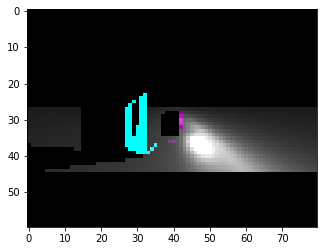

In [ ]:
cs = driver()
# plt.imsave('image.png', cs.image)
plt.imshow(cs.image)